In [1]:
import pandas as pd
from prophet import Prophet

from sklearn.metrics import accuracy_score

In [2]:
def train_valid_test(data, target, split):
    train, valid, test = split
    n = data.shape[0]
    train_end = int(train * n)
    valid_end = int(n * (train + valid))
    
    x_train, y_train = data[:train_end], target[:train_end]
    x_val, y_val = data[train_end:valid_end], target[train_end:valid_end]
    x_test, y_test = data[valid_end:], target[valid_end:]

    return x_train, y_train, x_val, y_val, x_test, y_test

def preprocess_data(data):
    lag = 7
    result = data.copy()
    result['ema'] = result['close'].ewm(span=lag).mean()
    for i in range(1, lag+1):
        result['lag_' + str(i)] = result['close'].shift(i)

    result = result.iloc[lag:]
    # Assuming df is your DataFrame and it has 'day' and 'month' columns
    result['month_sin'] = np.sin(2 * np.pi * result['month']/12)
    result['month_cos'] = np.cos(2 * np.pi * result['month']/12)
    result['day_sin'] = np.sin(2 * np.pi * result['day']/31)
    result['day_cos'] = np.cos(2 * np.pi * result['day']/31)
    return result

In [3]:
data = pd.read_csv('apple_processed_data.csv')
data.head()

,Unnamed: 0,Date,close,open,lowest,highest,total_vol,mean_vol,std_vol,news,month,day,is_up
0,0,2015-01-02,24.490,24.925,24.026,24.992,188181988,482517.917949,453958.983288,"[""Is Xiaomi's first laptop a MacBook Air knock...",1,2,0
1,1,2015-01-05,23.807,24.192,23.592,24.366,200586492,514324.338462,426711.446836,"[""Is Xiaomi's first laptop a MacBook Air knock...",1,5,0
2,2,2015-01-06,23.802,23.842,23.417,24.092,237766160,609656.820513,452106.984355,"[""Is Xiaomi's first laptop a MacBook Air knock...",1,6,1
3,3,2015-01-07,24.143,24.017,23.879,24.265,137809632,353358.030769,315345.332594,Apple aims at bendable devices\nA newly issued...,1,7,1
4,4,2015-01-08,25.066,24.391,24.328,25.151,201020076,515436.092308,344928.788130,"Xiaomi's buying spree gives Apple, Samsung mor...",1,8,1


In [4]:
x_train, y_train, x_val, y_val, x_test, y_test = train_valid_test(data['Date'], data['close'], (0.6, 0.2, 0.2))

In [6]:
prophet_df = pd.DataFrame({
    'ds': x_train, 'y': y_train
})
m = Prophet()
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.fit(prophet_df)

20:05:42 - cmdstanpy - INFO - Chain [1] start processing
20:05:42 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
future = m.make_future_dataframe(periods=x_train.shape[0] + x_val.shape[0])
future.shape

(3111, 1)

In [8]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3106,2025-02-27,209.995482,47.075255,363.589828
3107,2025-02-28,209.792539,45.998877,365.092268
3108,2025-03-01,208.512855,44.877579,361.199588
3109,2025-03-02,208.436921,43.183730,365.491829
3110,2025-03-03,209.554065,44.362866,362.949223


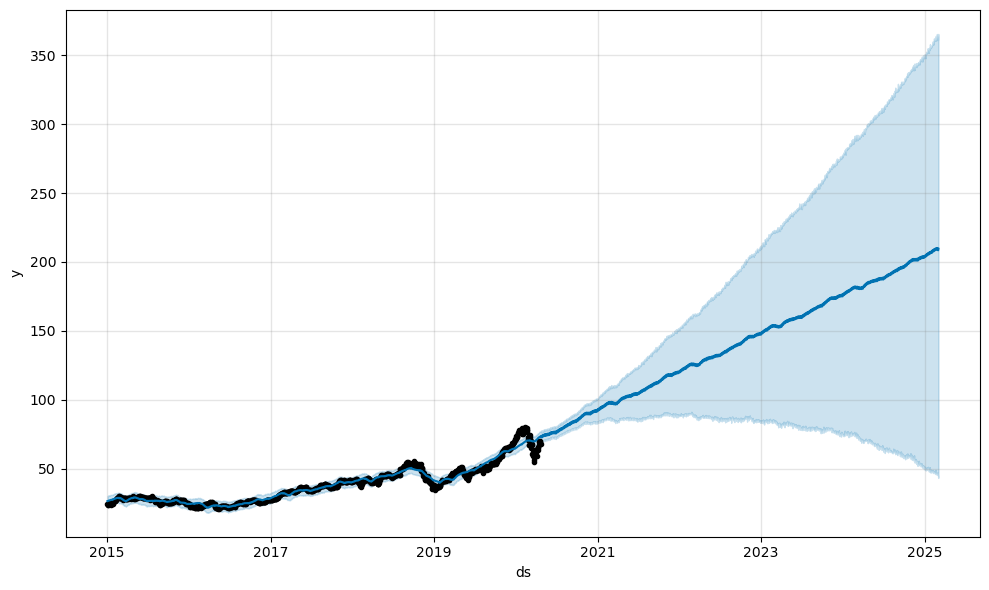

In [9]:
fig1 = m.plot(forecast)

In [10]:
y_val_pred = forecast['yhat'][-y_val.shape[0]:]
len(y_val_pred)

445

In [11]:
validation_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][x_train.shape[0] + 1:x_train.shape[0]+x_val.shape[0] + 1]

In [12]:
validation_forecast

,ds,yhat,yhat_lower,yhat_upper
1334,2020-04-22,73.667888,69.736230,77.354506
1335,2020-04-23,73.751061,70.130639,77.278461
1336,2020-04-24,73.740817,70.250559,77.624408
1337,2020-04-25,72.614516,69.131408,76.016674
1338,2020-04-26,72.587297,69.034257,75.998423
...,...,...,...,...
1774,2021-07-06,105.422646,86.169315,124.881583
1775,2021-07-07,105.565188,86.244327,124.735842
1776,2021-07-08,105.723039,85.647191,125.089077
1777,2021-07-09,105.805040,85.470609,124.780310


In [13]:
x_val

1333    2020-04-21
1334    2020-04-22
1335    2020-04-23
1336    2020-04-24
1337    2020-04-27
           ...    
1773    2022-01-18
1774    2022-01-19
1775    2022-01-20
1776    2022-01-21
1777    2022-01-24
Name: Date, Length: 445, dtype: object

In [14]:
val_df = pd.DataFrame({
    'date': x_val,
    'y': y_val,
    'yhat': validation_forecast['yhat']
})
val_df.head()

,date,y,yhat
1333,2020-04-21,65.604,NaN
1334,2020-04-22,67.496,73.667888
1335,2020-04-23,67.195,73.751061
1336,2020-04-24,69.171,73.740817
1337,2020-04-27,69.244,72.614516


In [15]:
val_df['yhat'] = val_df['yhat'].shift(-1)


In [16]:
val_df.tail()

,date,y,yhat
1774,2022-01-19,164.548,105.565188
1775,2022-01-20,162.875,105.723039
1776,2022-01-21,160.786,105.805040
1777,2022-01-24,160.568,104.778847
1778,NaN,NaN,NaN


In [17]:
val_clean_df = val_df[:-1]

In [18]:
y_val_pred = (val_clean_df['yhat'] > val_clean_df['y']).astype(int)
y_val_pred

1333    1
1334    1
1335    1
1336    1
1337    1
       ..
1773    0
1774    0
1775    0
1776    0
1777    0
Length: 445, dtype: int32

In [19]:
y_val_bin = data.iloc[y_val.index]['is_up']
accuracy_score(y_val_bin, y_val_pred)

0.47415730337078654

In [20]:
val_clean_df.head(10)

,date,y,yhat
1333,2020-04-21,65.604,73.667888
1334,2020-04-22,67.496,73.751061
1335,2020-04-23,67.195,73.740817
1336,2020-04-24,69.171,72.614516
1337,2020-04-27,69.244,72.587297
1338,2020-04-28,68.100,73.652859
1339,2020-04-29,70.363,73.802835
1340,2020-04-30,71.869,73.949806
1341,2020-05-01,70.664,74.141872
1342,2020-05-04,71.667,74.264510
